# Autoencoders Using CNN

We're using a convolutional neural network in the encoder and decoder architectures here.

## Encoder
The encoder architecture has -
- Conv2d, ReLU, MaxPool2d --> Output = `[16, 14, 14]`
- Conv2d, ReLU, MaxPool2d --> Output = `[32, 6, 6]`
- Conv2d --> Output = `[64, 1, 1]`

## Latent Space Representation
The latent space representation or code has size `[64, 1, 1]` thus representing an image by 64 values.

## Decoder
The decoder architecture has -
- ConvTranspose2d, ReLU --> Output = `[32, 7, 7]`
- ConvTranspose2d, ReLU --> Output = `[16, 14, 14]`
- ConvTranspose2d, ReLU --> Output = `[1, 28, 28]`

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_workers = os.cpu_count()
batch_size = 32

# Creating transforms for dataloader.
data_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True)
])

# Creating the dataloaders
train_data = datasets.MNIST(root='./data', train=True, transform=data_transforms, download=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_data = datasets.MNIST(root='./data', train=False, transform=data_transforms, download=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/Users/suryanshsinha/Desktop/cDCGAN/.cDCGAN/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Creating AutoEncoder
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1, 1),  # Output --> [16, 28, 28]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output --> [16, 14, 14]
        nn.Conv2d(16, 32, 3, 1),  # Output --> [32, 12, 12]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output --> [32, 6, 6]
        nn.Conv2d(32, 64, 6)  # Output --> [64, 1, 1]
    )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),  # Output --> [32, 7, 7]
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # Output --> [16, 14, 14]
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1), # Output --> [1, 28, 28]
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.decoder(self.encoder(x))

In [3]:
model = Autoencoder().to(device)
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 28, 28]               --
├─Sequential: 1-1                        [64, 1, 1]                --
│    └─Conv2d: 2-1                       [16, 28, 28]              160
│    └─ReLU: 2-2                         [16, 28, 28]              --
│    └─MaxPool2d: 2-3                    [16, 14, 14]              --
│    └─Conv2d: 2-4                       [32, 12, 12]              4,640
│    └─ReLU: 2-5                         [32, 12, 12]              --
│    └─MaxPool2d: 2-6                    [32, 6, 6]                --
│    └─Conv2d: 2-7                       [64, 1, 1]                73,792
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-8              [32, 7, 7]                100,384
│    └─ReLU: 2-9                         [32, 7, 7]                --
│    └─ConvTranspose2d: 2-10             [16, 14, 14]              4,624

In [4]:
# Defining loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [5]:
# Training
n_epochs = 10
for epoch in range(n_epochs):

  train_loss = 0

  for img, _ in tqdm(train_dataloader):
    # Move image to target device
    img = img.to(device)
    
    # Get reconstructed image
    output_img = model(img)
    
    # Calculate reconstruction loss
    loss = loss_fn(output_img, img)
    
    # Update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Accumulate loss which is to be averaged later.
    train_loss += loss.item()*img.size(0)

  # Average loss per batch
  train_loss /= len(train_dataloader)
  print('Epoch: [{}/{}] | Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:40<00:00, 46.05it/s]


Epoch: [1/10] | Loss: 0.8253


100%|██████████| 1875/1875 [00:39<00:00, 47.31it/s]


Epoch: [2/10] | Loss: 0.2214


100%|██████████| 1875/1875 [00:39<00:00, 47.09it/s]


Epoch: [3/10] | Loss: 0.1678


100%|██████████| 1875/1875 [00:39<00:00, 47.52it/s]


Epoch: [4/10] | Loss: 0.1425


100%|██████████| 1875/1875 [00:39<00:00, 47.74it/s]


Epoch: [5/10] | Loss: 0.1285


100%|██████████| 1875/1875 [00:39<00:00, 47.17it/s]


Epoch: [6/10] | Loss: 0.1198


100%|██████████| 1875/1875 [00:40<00:00, 46.84it/s]


Epoch: [7/10] | Loss: 0.1140


100%|██████████| 1875/1875 [00:39<00:00, 47.34it/s]


Epoch: [8/10] | Loss: 0.1099


100%|██████████| 1875/1875 [00:39<00:00, 47.13it/s]


Epoch: [9/10] | Loss: 0.1075


100%|██████████| 1875/1875 [00:39<00:00, 47.28it/s]


Epoch: [10/10] | Loss: 0.1052


In [6]:
def show_result(dataloader):
  img, _ = next(iter(dataloader))

  # Moving images to target device
  img = img.to(device)
  
  # Plot original images
  plt.figure(figsize=(9, 3))
  for i in range(0, 9):
    plt.subplot(2, 9, i+1)
    image = img[i].cpu().permute(1, 2, 0)
    plt.imshow(image, cmap='gray')
    plt.axis(False)
  plt.suptitle(f"Original Images", fontsize=20)

  # Get the output from model and plot reconstructed images
  model.eval()
  with torch.inference_mode():
    plt.figure(figsize=(9, 3))
    output = model(img)
    for i in range(0, 9):
      plt.subplot(2, 9, i+1)
      image = output[i].cpu().permute(1, 2, 0)
      plt.imshow(image, cmap='gray')
      plt.axis(False)
    plt.suptitle("Reconstructed Images", fontsize=20)

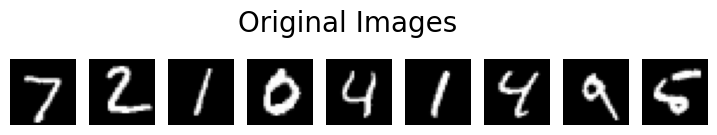

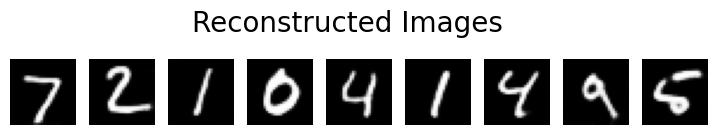

In [7]:
show_result(test_dataloader)